In [1]:
from datasets.wider_part_dataset import build_wider_dataloader
from datasets.text_test_datasets import build_text_test_loader
from datasets.image_test_datasets import build_image_test_loader

from models.encoder import Model, MLP
from evaluators.global_evaluator import GlobalEvaluator
from evaluators.np_evaluator import NPEvaluator
from loss.loss import crossmodal_triplet_loss, cos_distance, triplet_cos_loss
from loggers.logger import Logger
from manager import build_graph_optimizer
from tqdm import tqdm_notebook as tqdm
from sklearn.neighbors import DistanceMetric

from attentions.rga_attention import RGA_attend_one_to_many_batch, RGA_attend_one_to_many
import os

import torch.nn as nn
import torch.optim as optim

from configs.args import load_arg_parser

In [2]:
parser = load_arg_parser()
cfg = parser.parse_args("")
cfg.data_root = "/data/aiyucui2/wider"
root = cfg.data_root

# data path
mask_root = "/shared/rsaas/aiyucui2/wider_person/wider/{}/"

cfg.anno_path = os.path.join(root, cfg.anno_path)
cfg.img_dir = os.path.join(root, cfg.img_dir)
cfg.mask_dir = os.path.join(mask_root.format('train'), "aiyu_binary_masks")

cfg.val_anno_path = os.path.join(root, cfg.val_anno_path)
cfg.val_img_dir = os.path.join(root, cfg.val_img_dir)
cfg.val_mask_dir = os.path.join(mask_root.format('val1'), "aiyu_binary_masks")

cfg.gt_file_fn = os.path.join(root, cfg.gt_file_fn)

# meta data path
cfg.cheap_candidate_fn = os.path.join(root, cfg.cheap_candidate_fn)
cfg.vocab_path = os.path.join(root, cfg.vocab_path)
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
# sys path
cfg.model_path = os.path.join(root, cfg.model_path)
cfg.output_path = os.path.join(root, cfg.output_path)
ckpt_root = "/shared/rsaas/aiyucui2/wider_person/checkpoints/reID/baseline"
load_exp_name = "dist_fn_cosine_imgbb_resnet50_capbb_bigru_embed_size_1024_batch_96_lr_0.0002_step_size_10_captype_sent_img_meltlayer_6_np_False_sent_60_cap_10_6_fix_img_melt"
#"dist_fn_cosine_imgbb_resnet50_capbb_bigru_embed_size_1024_batch_96_lr_0.0001_captype_sent_img_meltlayer_2_cos_margin_0.2_np_False"
cfg.load_ckpt_fn = os.path.join(ckpt_root, load_exp_name, "stage_1_id_last.pt")
cfg.debug = False
cfg.embed_size = 1024
cfg.batch_size = 96
cfg.img_backbone_opt = "resnet50"
cfg.num_gpus = 1
cfg.cap_backbone_opt = "bigru"
cfg.dim = (384,128)
cfg.dist_fn_opt = "cosine"
cfg.np = True
cfg.img_num_cut = 6
cfg.img_num_cut = 1 if not cfg.np else cfg.img_num_cut
cfg.mask = True

cfg.sent_token_length = 60
cfg.np_token_length = 6
cfg.num_np_per_sent = 10

cfg.cap_embed_type='sent'
# exp_name
cfg.exp_name = 'debug'
cfg.model_path = os.path.join("/shared/rsaas/aiyucui2/wider_person", cfg.model_path, cfg.exp_name)
cfg.output_path = os.path.join("/shared/rsaas/aiyucui2/wider_person", cfg.output_path, cfg.exp_name)

if not os.path.exists(cfg.model_path):
    os.mkdir(cfg.model_path)
if not os.path.exists(cfg.output_path):
    os.mkdir(cfg.output_path)
# logger
logger = Logger("test.txt") #os.path.join(cfg.output_path, cfg.exp_name+".txt"))
print(cfg.exp_name)

debug


In [3]:
#cfg.mask_dir = os.path.join(root, cfg.mask_dir)
print(root)
print(cfg.mask_dir)

/data/aiyucui2/wider
/shared/rsaas/aiyucui2/wider_person/wider/train/aiyu_binary_masks


In [4]:
from evaluators.evaluator import *
import torch
import numpy as np
from attentions.rga_attention import RGA_attend_one_to_many_batch
from sklearn.neighbors import DistanceMetric
from loss.loss import cos_distance
import torch.nn.functional as F


class NPEvaluator(Evaluator):
    def __init__(self, img_loader, cap_loader, gt_file_path,  embed_size, logger, dist_fn_opt):
        super(NPEvaluator, self).__init__(img_loader, cap_loader, gt_file_path,  embed_size, logger)
        # dist fn
        self.dist_fn_opt = dist_fn_opt
        if dist_fn_opt == 'euclidean':
            self.dist = DistanceMetric.get_metric('euclidean').pairwise
        else:
            self.dist = cos_distance
        
    def populate_img_db(self, encoder, img_mlp):
        K = self.embed_size
        self.global_imgs = []
        self.img_parts = []
        self.num_cnts = []
        encoder.eval(); img_mlp.eval()
        with torch.no_grad():
            for i, data in tqdm(enumerate(self.img_loader),desc='build db global imgs'):
                img, mask, file_names = data
                img_em, img_part, num_cnts = encoder(img.cuda(), mask.cuda())
                self.num_cnts.extend(num_cnts)
                self.img_parts.append(img_mlp(img_part))
                self.global_imgs.append(img_em)
        self.global_imgs = torch.cat(self.global_imgs)
        self.img_parts = torch.cat(self.img_parts)
        #self.num_cnts = torch.cat(self.num_cnts)
        return self.global_imgs
    
    def populate_cap_db(self, encoder, text_mlp):
        K = self.embed_size
        encoder.eval(); text_mlp.eval()
        self.global_caps = []
        self.cap_parts = []
        self.n2cs = []
        with torch.no_grad():
            for i, batch in tqdm(enumerate(self.cap_loader),desc='build db global caps'):
                caps, nps, n2c, file_names = batch
                N, M, T = nps.size()
                global_cap = encoder(caps.cuda())
                nps = encoder(nps.reshape(N*M, T).cuda())
                self.global_caps.append(global_cap)
                self.n2cs.append(n2c)
                self.cap_parts.append(text_mlp(nps).reshape(N, M, -1))
        self.global_caps = torch.cat(self.global_caps)
        self.cap_parts = torch.cat(self.cap_parts)
        self.n2cs = torch.cat(self.n2cs)
        return self.global_caps
    
    def regional_alignment_image(self, caps, img_parts, dist_fn_opt):
        scoremats = []
        #N, M, K = img_parts.size()
        start = 0
        for num in tqdm(self.num_cnts, "scoremat_rga_img"):
            with torch.no_grad():
                curr_parts = img_parts[None, start:start+num,:].expand(caps.size(0), num, caps.size(1))
                start += num
                parts = RGA_attend_one_to_many_batch(caps, curr_parts, dist_fn_opt)
                if dist_fn_opt == "cosine":
                    scores = 1 - F.cosine_similarity(caps, parts)
                else:
                    scores = F.pairwise_distance(caps, parts)
                scoremats.append(scores.detach().cpu().numpy())
        import pdb; pdb.set_trace()
        return np.array(scoremats).transpose(1,0)
    
    def regional_alignment_text(self, imgs, cap_parts, n2cs, dist_fn_opt):
        scoremats = []
        N, M, K = cap_parts.size()
        for cap_part, n2c in tqdm(zip(cap_parts, n2cs), "scoremat_rga_cap(nps)"):
            with torch.no_grad():
                parts = RGA_attend_one_to_many_batch(imgs, cap_part[None,:n2c,:].expand(imgs.size(0), n2c, imgs.size(1)), dist_fn_opt)
                if dist_fn_opt == "cosine":
                    scores = 1 - F.cosine_similarity(imgs, parts)
                else:
                    scores = F.pairwise_distance(imgs, parts)
                scoremats.append(scores.detach().cpu().numpy())
        return np.array(scoremats)
    
    def evaluate(self, encoder, mlp_img, mlp_text, output_path="tmp.txt"):
        # compute global features
        self.populate_img_db(encoder, mlp_img)
        self.populate_cap_db(encoder, mlp_text)
    
        # global eval
        # scoremat = self.retrieval()
        scoremat_global, scoremat_img_rga, scoremat_cap_rga = self.retrieval()
        import pdb; pdb.set_trace()
        acc = self.compute_acc(scoremat_global, output_path)
        self.logger.log("[global] R@1: %.4f | R@5: %.4f | R@10: %.4f" % (acc['top-1'], acc['top-5'], acc['top-10']))
        acc = self.compute_acc(scoremat_img_rga, output_path)
        self.logger.log("[img_rga] R@1: %.4f | R@5: %.4f | R@10: %.4f" % (acc['top-1'], acc['top-5'], acc['top-10']))
        acc = self.compute_acc(scoremat_cap_rga, output_path)
        self.logger.log("[cap_rga] R@1: %.4f | R@5: %.4f | R@10: %.4f" % (acc['top-1'], acc['top-5'], acc['top-10']))
        
        acc = self.compute_acc(scoremat_global + 0.5*scoremat_img_rga + 0.5*scoremat_cap_rga, output_path)
        self.logger.log("[fusion] R@1: %.4f | R@5: %.4f | R@10: %.4f" % (acc['top-1'], acc['top-5'], acc['top-10']))
        return acc                         
            
    
    def retrieval(self):
        querys = self.global_caps.cpu().detach().numpy()
        candidates = self.global_imgs.cpu().detach().numpy()
        scoremat = self.dist(querys, candidates)
        scoremat2 = self.regional_alignment_image(self.global_caps, self.img_parts, self.dist_fn_opt)
        scoremat3 = self.regional_alignment_text(self.global_imgs, self.cap_parts, self.n2cs, self.dist_fn_opt)
        return scoremat, scoremat2, scoremat3

In [5]:
# train loader
train_loader = build_wider_dataloader(cfg)
# test loader (loading image and text separately)
test_text_loader = build_text_test_loader(cfg) 
test_image_loader = build_image_test_loader(cfg) 

# Evaluator
Evaluator = NPEvaluator if cfg.np else GlobalEvaluator

evaluator = Evaluator(img_loader=test_image_loader, 
                          cap_loader=test_text_loader, 
                          gt_file_path=cfg.gt_file_fn,
                          embed_size=cfg.embed_size,
                          logger=logger,
                          dist_fn_opt="euclidean")
cos_evaluator = Evaluator(img_loader=test_image_loader, 
                          cap_loader=test_text_loader, 
                          gt_file_path=cfg.gt_file_fn,
                          embed_size=cfg.embed_size,
                          logger=logger,
                          dist_fn_opt="cosine")

[ds] load annotations from /data/aiyucui2/wider/wider/train/train_anns_train.json
size of dataset: 74264


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


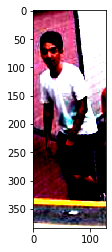

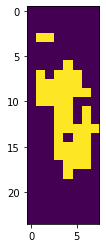

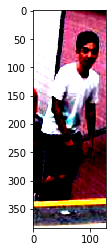

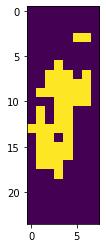

In [6]:
#normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                     std=[0.229, 0.224, 0.225])
if True:
    import torch
    ds = test_image_loader.dataset
    image, mask, img_fn = ds[24]
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure()
    plt.imshow(image.numpy().transpose(1,2,0))
    plt.figure()
    plt.imshow(mask.sum(0).numpy())
    new_image = torch.flip(image,[2])
    new_mask = torch.flip(mask.sum(0), [1])
    plt.figure()
    plt.imshow(new_image.numpy().transpose(1,2,0))
    plt.figure()
    plt.imshow(new_mask.numpy())

In [7]:
print(mask.sum(0))

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 1., 1., 1., 0., 0.],
        [0., 1., 1., 1., 1., 1., 0., 0.],
        [0., 1., 1., 1., 1., 1., 1., 0.],
        [0., 1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 1., 0.],
        [0., 0., 0., 1., 1., 0., 1., 0.],
        [0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 0., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0

In [8]:
# import torch.nn as nn
import torchvision.models as models
import torch
import torch.nn as nn
import torch.nn.functional as F 
from models.texts.gru_backbone import BiGRUBackbone as CaptionBackbone


class ImageMaskBackbone(nn.Module):
    def __init__(self,embed_size, regional_embed_size=256, num_cut=1, model='resnet50',coco=False):
        super(ImageMaskBackbone,self).__init__()
        self.num_cut = num_cut
        self.hidden_size = 512 if model =='resnet18' else 2048
        if model == 'resnet101' or coco:
            self.img_backbone=models.resnet101(pretrained=True)
        elif model == 'resnet50':
            self.img_backbone=models.resnet50(pretrained=True)
        elif model =='resnet18':
            self.img_backbone=models.resnet18(pretrained=True)
        else:
            assert False
        self.img_backbone.fc=nn.Linear(self.hidden_size,embed_size)
        self.melt_layer()
        
        if num_cut > 1:
            self.conv_regional = nn.Conv2d(self.hidden_size, regional_embed_size, 1)
        
    def extract_feature_map(self, x):
        out = self.img_backbone.conv1(x)
        out = self.img_backbone.bn1(out)
        out = self.img_backbone.relu(out)
        out = self.img_backbone.maxpool(out)
        out = self.img_backbone.layer1(out)
        out = self.img_backbone.layer2(out)
        out = self.img_backbone.layer3(out)
        out = self.img_backbone.layer4(out)
        return out
    
    def mlp(self, x):
        #x = self.img_backbone.layer4(x)
        x = self.img_backbone.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.img_backbone.fc(x)
        return x
    
    
    def regional_extract(self,x):
        x = self.conv_regional(x)
        x = self.img_backbone.avgpool(x)
        x = torch.flatten(x, 1)
        return x
        
    def forward(self,x, masks):
        out = self.extract_feature_map(x)
        global_features = self.mlp(out)
        N, E, H, W = out.size()
        masks.resize_((N, 8, H, W))
        ret = []
        cuts = []
        num_cuts = []
        for b in range(N):
            before = len(cuts)
            for i in range(8):
                mask = masks[b, i:i+1, :, :]
                if mask.sum() > 0:
                    mask = mask.expand_as(out[b]) # 2048 x M x N
                    cut = mask * out[b] 
                    cuts.append(cut[None])
            after = len(cuts)
            if before == after:
                cuts.append(out[b:b+1])
                after = len(cuts)
            num_cuts.append(after - before)
            before = after
                
        regional_feature = self.regional_extract(torch.cat(cuts))
        return global_features, regional_feature, num_cuts
        before = 0
        for num in num_cuts:
            curr_maps = regional_feature[before:before+num]
            ret.append(curr_maps.mean(0, keepdim=True))
            before += num
        regional_features = torch.cat(ret)
        return global_features, regional_features

        
    
    def melt_layer(self,forzen_util=7):
        ct = 0
        for child in self.img_backbone.children():
            ct += 1
            if ct < forzen_util:
                for param in child.parameters():
                    param.requires_grad = False
            else:
                for param in child.parameters():
                    param.requires_grad = True
                    
                    
class Model(nn.Module):
    def __init__(self, embed_size, image_opt="resnet50", caption_opt="bigru", cap_embed_type="sent", img_num_cut=1, regional_embed_size=256):
        super(Model, self).__init__()
        self.img_backbone = ImageMaskBackbone(embed_size, regional_embed_size=256, num_cut=img_num_cut, model=image_opt)
        self.cap_backbone = CaptionBackbone(embed_size=embed_size, caption_opt=caption_opt,cap_embed_type=cap_embed_type)
        
    def forward(self, x, mask=None):
        if len(x.size()) == 4:
            x = self.img_backbone(x, mask)
        elif len(x.size()) == 2 or len(x.size()) == 3:
            x = self.cap_backbone(x)
        else:
            assert False
        return x      
      
    
    def img_frezee_layer(self, num_layer_to_frezee):
        self.img_backbone.melt_layer(num_layer_to_frezee)
    

In [9]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim 
import os

import torch.nn.functional as F
from models.encoder import MLP
from loss.loss import triplet_cos_loss, crossmodal_triplet_loss

from attentions.rga_attention import RGA_attend_one_to_many_batch, RGA_attend_one_to_many

def regional_alignment_text_new(fulls, parts, p2fs, dist_fn_opt):
    aligned = []
    
    for i, jump in enumerate(p2fs):
        curr_parts = parts[i,:jump,:]
        curr_full = fulls[i:i+1]
        aligned.append(RGA_attend_one_to_many(curr_full, curr_parts, dist_fn_opt))
    return torch.cat(aligned)   

def regional_alignment_text(fulls, parts, p2fs, dist_fn_opt):
    aligned = []
    start = 0
    for i, jump in enumerate(p2fs):
        curr_parts = parts[start: start+jump,:]
        curr_full = fulls[i:i+1]
        start = start+jump
        aligned.append(RGA_attend_one_to_many(curr_full, curr_parts, dist_fn_opt))
    return torch.cat(aligned)

def regional_alignment_image(fulls, parts, dist_fn_opt):
    return RGA_attend_one_to_many_batch(fulls, parts, dist_fn_opt)
  
    
class Manager:
    def __init__(self, args, logger):
        self.log = logger.log
        self.cfg = args
        self._init_models()
        self._init_criterion()
    
    def _init_criterion(self):
        if self.cfg.dist_fn_opt == "cosine":
            self.triplet_loss = triplet_cos_loss
        elif self.cfg.dist_fn_opt == "euclidean":
            self.triplet_loss = nn.TripletMarginLoss()
        self.cls_loss = nn.CrossEntropyLoss()
        self.log("[Trainer][init] criterion initialized.")

    def _init_models(self):
        # encoder
        self.model = Model(embed_size=self.cfg.embed_size, 
                          image_opt=self.cfg.img_backbone_opt, 
                          caption_opt=self.cfg.cap_backbone_opt,
                          cap_embed_type=self.cfg.cap_embed_type,
                          img_num_cut=self.cfg.img_num_cut,
                          regional_embed_size=self.cfg.regional_embed_size).cuda()
        # id classifer
        self.id_cls = nn.Linear(self.cfg.embed_size, self.cfg.num_ids).cuda()
        # RGA image mlp
        self.rga_img_mlp = MLP(self.cfg.regional_embed_size, self.cfg.embed_size).cuda()
        # RGA text mlp
        self.rga_cap_mlp = MLP(self.cfg.embed_size, self.cfg.embed_size).cuda()
    
        # gpu
        self.all_models = {
            "model": self.model,
            "id_cls": self.id_cls, 
            "rga_img_mlp": self.rga_img_mlp,
            "rga_cap_mlp": self.rga_cap_mlp,
        }
        print(self.cfg.num_gpus)
        if self.cfg.num_gpus > 1:
            print('here')
            for name in self.all_models.keys():
                print('data parallel')
                self.all_models[name] = nn.DataParallel(self.all_models[name])
        # load ckpt
        self.reset_ckpt()
        
        
        self.log("[Trainer][init] model initialized.")

    def reset_ckpt(self):
        self.start_epoch = 0
        self.acc_history = []
        self.best_acc = ({'top-1':0, 'top-1': 0, 'top-1': 0}, self.start_epoch)
        if self.cfg.load_ckpt_fn == "0":
            self.log("[Trainer][init] initialize fresh model.")
            return
        ckpt = torch.load(self.cfg.load_ckpt_fn)
        self.start_epoch = ckpt["epoch"] + 1
        self.acc_history = ckpt["acc_history"]
        for name, network in self.all_models.items():
            if name in ckpt:
                network.load_state_dict(ckpt[name], strict=False)
                self.log("[Trainer][init] load pre-trained %s from %s." % (name, self.cfg.load_ckpt_fn))

              
    def save_ckpt(self, epoch, acc, fn):
        # update acc history 
        self.acc_history.append((acc, epoch))
        if acc['top-1'] > self.best_acc[0]['top-1']:
            self.best_acc = (acc, epoch)
        # ckpt 
        ckpt = {
            "epoch": epoch,
            "acc_history": self.acc_history,
            "best_acc": self.best_acc,
            }
        for name, network in self.all_models.items():
            ckpt[name] = network.module.state_dict() if isinstance(network, nn.DataParallel) else network.state_dict()

        path = os.path.join(self.cfg.model_path, fn)
        torch.save(ckpt, path)
            
    def todevice(self, batch):
        ret = []
        for arg in batch:
            if isinstance(arg, torch.Tensor):
                arg = arg.cuda()
            ret.append(arg)
        return tuple(ret)
    
    def melt_img_layer(self, num_layer_to_melt=1):
        if isinstance(self.model, nn.DataParallel):
            self.model.module.img_backbone.melt_layer(8 - num_layer_to_melt)
        else:
            self.model.img_backbone.melt_layer(8 - num_layer_to_melt)
     
    def train_epoch_global(self, train_data, optimizer, epoch, note="train"):
        self.model.train()
        cum_tri_loss, cum_id_loss = 0.0, 0.0
        for i, data in tqdm(enumerate(train_data), "%s, epoch%d" % (note, epoch)):
            # load data
            data = self.todevice(data)
            img, cap, pid = data
            
            # encode
            #img, pos_img, neg_img = self.model(img), self.model(pos_img), self.model(neg_img)
            #cap, pos_cap, neg_cap = self.model(cap), self.model(pos_cap), self.model(neg_cap)
            img, cap = self.model(img), self.model(cap)


            # loss
            tri_loss = triplet_cos_loss(img, cap, pid)
            id_loss = self.cls_loss(self.id_cls(img), pid) + self.cls_loss(self.id_cls(cap), pid)
            loss = tri_loss + id_loss

            # backpropagation
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            # log
            cum_tri_loss += tri_loss.item()
            cum_id_loss += id_loss.item()
            if (i+1) % self.cfg.print_freq == 0:
                out_string = "[ep-%d, bs-%d] " % (epoch, i)
                out_string += "[tri-loss] %.6f, " % (cum_tri_loss / self.cfg.print_freq)
                out_string += "[id-loss] %.6f, " % (cum_id_loss / self.cfg.print_freq)
                self.log(out_string)
                cum_tri_loss, cum_id_loss = 0.0, 0.0
                
    def train_epoch_regional(self, train_data, optimizer, epoch, note="train"):
        self.model.train(); self.rga_img_mlp.train(); self.rga_cap_mlp.train();

        cum_tri_loss, cum_tri_image_regional_loss, cum_tri_text_regional_loss, cum_id_loss = 0.0, 0.0, 0.0, 0.0
        for i, data in tqdm(enumerate(train_data), "%s, epoch%d" % (note,epoch)):
            # load data
            data = self.todevice(data)
            (img, mask, cap, nps, n2c, pid) = data

            img, img_part, num_cuts = self.model(img, mask)
            cap = self.model(cap)
            
            N, M, T = nps.size()
            #nps = self.rga_cap_mlp(self.np_encoder(nps))
            #nps = self.rga_cap_mlp(self.model(nps.reshape(-1, T))).reshape(N, M, -1)
            
            # part
            img_part = self.rga_img_mlp(img_part)

            img_part = regional_alignment_text(cap, img_part, num_cuts, self.cfg.dist_fn_opt) #RGA_attend_one_to_many_batch(cap, img_part, self.cfg.dist_fn_opt)
            #cap_part = regional_alignment_text(img, nps, n2c, self.cfg.dist_fn_opt)
            #cap_part = RGA_attend_one_to_many_batch(img, nps, self.cfg.dist_fn_opt)

            # loss
            tri_loss =  self.triplet_loss(img, cap, pid) 
            #tri_text_regional_loss =  self.triplet_loss(img, cap_part, pid) 
            tri_image_regional_loss =  self.triplet_loss(cap, img_part, pid) 
            id_loss = self.cls_loss(self.id_cls(img), pid) +  self.cls_loss(self.id_cls(cap), pid)


            loss = tri_loss + tri_image_regional_loss + id_loss #  + tri_text_regional_loss

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            # log
            cum_tri_loss += tri_loss.item()
            cum_tri_image_regional_loss += tri_image_regional_loss.item()
            # cum_tri_text_regional_loss += tri_text_regional_loss.item()
            cum_id_loss += id_loss.item()
            
            if (i+1) % self.cfg.print_freq == 0:
                out_string = "[ep-%d, bs-%d] " % (epoch, i)
                out_string += "[id-loss] %.6f, " % (cum_id_loss / self.cfg.print_freq)
                out_string += "[tri-loss] %.6f, " % (cum_tri_loss / self.cfg.print_freq)
                out_string += "[img_rga] %.6f, " %  (cum_tri_image_regional_loss / self.cfg.print_freq)
                out_string += "[cap_rga] %.6f " % (cum_tri_text_regional_loss / self.cfg.print_freq)
                self.log(out_string)
                cum_tri_loss, cum_tri_image_regional_loss, cum_tri_text_regional_loss, cum_id_loss = 0.0, 0.0, 0.0, 0.0       
    def train_epoch_id(self, train_data, optimizer, epoch, note="train"):
        self.model.train()
        self.id_cls.train()
        cum_loss = 0.0
        for i, data in tqdm(enumerate(train_data), "%s, epoch%d" % (note,epoch)):
            # load data
            data = self.todevice(data)
            (img, cap, pid) = data
            img = self.model(img)
            cap = self.model(cap)

            # loss
            loss = 0.0
            loss = loss + self.cls_loss(self.id_cls(img), pid) +  self.cls_loss(self.id_cls(cap), pid)
            cum_loss += loss.item()
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            

            # log
            if (i+1) % self.cfg.print_freq == 0:
                self.log("ep-%d, bs-%d, [id-loss] %.6f" % (epoch, i, cum_loss / self.cfg.print_freq))
                cum_loss = 0.0

In [10]:
cfg.num_ids = len(train_loader.dataset.person2label.values())
manager = Manager(cfg, logger)

1
[Trainer][init] load pre-trained model from /shared/rsaas/aiyucui2/wider_person/checkpoints/reID/baseline/dist_fn_cosine_imgbb_resnet50_capbb_bigru_embed_size_1024_batch_96_lr_0.0002_step_size_10_captype_sent_img_meltlayer_6_np_False_sent_60_cap_10_6_fix_img_melt/stage_1_id_last.pt.
[Trainer][init] load pre-trained id_cls from /shared/rsaas/aiyucui2/wider_person/checkpoints/reID/baseline/dist_fn_cosine_imgbb_resnet50_capbb_bigru_embed_size_1024_batch_96_lr_0.0002_step_size_10_captype_sent_img_meltlayer_6_np_False_sent_60_cap_10_6_fix_img_melt/stage_1_id_last.pt.
[Trainer][init] load pre-trained rga_img_mlp from /shared/rsaas/aiyucui2/wider_person/checkpoints/reID/baseline/dist_fn_cosine_imgbb_resnet50_capbb_bigru_embed_size_1024_batch_96_lr_0.0002_step_size_10_captype_sent_img_meltlayer_6_np_False_sent_60_cap_10_6_fix_img_melt/stage_1_id_last.pt.
[Trainer][init] load pre-trained rga_cap_mlp from /shared/rsaas/aiyucui2/wider_person/checkpoints/reID/baseline/dist_fn_cosine_imgbb_resnet

In [11]:
if False:
    if cfg.np:
        acc = cos_evaluator.evaluate(manager.model, manager.rga_img_mlp, manager.rga_cap_mlp)
    else:
        acc = cos_evaluator.evaluate(manager.model)
    logger.log('[cosine   ][global] R@1: %.4f | R@5: %.4f | R@10: %.4f' % (acc['top-1'], acc['top-5'], acc['top-10']))


## Stage 1: ID Loss only

In [12]:

if False:
    logger.log("======== [Stage 1] ============")
    manager.melt_img_layer(num_layer_to_melt=1)
    param_to_optimize = build_graph_optimizer([manager.model, manager.id_cls])
    optimizer = optim.Adam(param_to_optimize, lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10)
    
    for epoch in range(0):
        manager.train_epoch_id(train_loader, optimizer, epoch, "train-stage-1")
        acc = evaluator.evaluate(manager.model)
        logger.log('[euclidean][global] R@1: %.4f | R@5: %.4f | R@10: %.4f' % (acc['top-1'], acc['top-5'], acc['top-10']))
        acc = cos_evaluator.evaluate(manager.model)
        logger.log('[cosine   ][global] R@1: %.4f | R@5: %.4f | R@10: %.4f' % (acc['top-1'], acc['top-5'], acc['top-10']))
        scheduler.step()
        manager.save_ckpt(epoch, acc, 'stage_1_id_last.pt')
    manager.save_ckpt(epoch, acc, 'id_initialized.pt')


## Stage 2: Matching + ID Loss

In [ ]:
from tqdm import tqdm_notebook as tqdm
manager.melt_img_layer(num_layer_to_melt=3)
param_to_optimize = build_graph_optimizer([manager.model, manager.id_cls])
optimizer = optim.Adam(param_to_optimize, lr=2e-4, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10)
train_epoch = manager.train_epoch_regional if cfg.np else manager.train_epoch_global
for epoch in range(15):
    train_epoch(train_loader, optimizer, epoch, "train-stage-2")
    if cfg.np:
        cos_acc = cos_evaluator.evaluate(manager.model, manager.rga_img_mlp, manager.rga_cap_mlp)
    else:
        cos_acc = cos_evaluator.evaluate(manager.model)
    logger.log('[cosine   ][global] R@1: %.4f | R@5: %.4f | R@10: %.4f' % (cos_acc['top-1'], cos_acc['top-5'], cos_acc['top-10']))
    scheduler.step()

[ep-0, bs-49] [id-loss] 3.078731, [tri-loss] 12.245416, [img_rga] 26.023119, [cap_rga] 0.000000 
[ep-0, bs-99] [id-loss] 2.985575, [tri-loss] 5.310125, [img_rga] 19.574588, [cap_rga] 0.000000 
[ep-0, bs-149] [id-loss] 3.792645, [tri-loss] 4.219028, [img_rga] 14.775048, [cap_rga] 0.000000 
[ep-0, bs-199] [id-loss] 4.348468, [tri-loss] 3.509865, [img_rga] 11.224974, [cap_rga] 0.000000 
[ep-0, bs-249] [id-loss] 4.343195, [tri-loss] 3.012444, [img_rga] 9.236499, [cap_rga] 0.000000 
[ep-0, bs-299] [id-loss] 4.107030, [tri-loss] 2.636675, [img_rga] 7.959398, [cap_rga] 0.000000 
[ep-0, bs-349] [id-loss] 3.971394, [tri-loss] 2.382365, [img_rga] 6.933376, [cap_rga] 0.000000 
[ep-0, bs-399] [id-loss] 3.297932, [tri-loss] 2.170229, [img_rga] 6.284121, [cap_rga] 0.000000 
[ep-0, bs-449] [id-loss] 3.213507, [tri-loss] 2.028612, [img_rga] 5.747965, [cap_rga] 0.000000 
[ep-0, bs-499] [id-loss] 2.732611, [tri-loss] 1.938702, [img_rga] 5.451291, [cap_rga] 0.000000 
[ep-0, bs-549] [id-loss] 2.422625, [t


> <ipython-input-4-616a6b5cdf57>(73)regional_alignment_image()
-> return np.array(scoremats).transpose(1,0)
(Pdb) c



> <ipython-input-4-616a6b5cdf57>(97)evaluate()
-> acc = self.compute_acc(scoremat_global, output_path)
(Pdb) c
[global] R@1: 0.3705 | R@5: 0.6126 | R@10: 0.7101
[img_rga] R@1: 0.2189 | R@5: 0.4502 | R@10: 0.5556
[cap_rga] R@1: 0.0013 | R@5: 0.0059 | R@10: 0.0091
[fusion] R@1: 0.3559 | R@5: 0.5940 | R@10: 0.6932
[cosine   ][global] R@1: 0.3559 | R@5: 0.5940 | R@10: 0.6932


[ep-1, bs-49] [id-loss] 0.496426, [tri-loss] 1.008112, [img_rga] 3.240440, [cap_rga] 0.000000 
[ep-1, bs-99] [id-loss] 0.480916, [tri-loss] 0.917633, [img_rga] 3.010802, [cap_rga] 0.000000 
[ep-1, bs-149] [id-loss] 0.505513, [tri-loss] 0.932427, [img_rga] 2.881308, [cap_rga] 0.000000 
[ep-1, bs-199] [id-loss] 0.490409, [tri-loss] 0.910388, [img_rga] 2.924159, [cap_rga] 0.000000 
[ep-1, bs-249] [id-loss] 0.547675, [tri-loss] 0.918140, [img_rga] 2.798573, [cap_rga] 0.000000 
[ep-1, bs-299] [id-loss] 0.533737, [tri-loss] 0.964821, [img_rga] 2.792914, [cap_rga] 0.000000 
[ep-1, bs-349] [id-loss] 0.544569, [tri-loss] 0.921646, [img_rga] 2.729030, [cap_rga] 0.000000 
[ep-1, bs-399] [id-loss] 0.516965, [tri-loss] 0.905187, [img_rga] 2.635051, [cap_rga] 0.000000 
[ep-1, bs-449] [id-loss] 0.538384, [tri-loss] 0.873349, [img_rga] 2.546358, [cap_rga] 0.000000 
[ep-1, bs-499] [id-loss] 0.535479, [tri-loss] 0.870708, [img_rga] 2.465056, [cap_rga] 0.000000 
[ep-1, bs-549] [id-loss] 0.551346, [tri-lo


> <ipython-input-4-616a6b5cdf57>(73)regional_alignment_image()
-> return np.array(scoremats).transpose(1,0)
(Pdb) c



> <ipython-input-4-616a6b5cdf57>(97)evaluate()
-> acc = self.compute_acc(scoremat_global, output_path)
(Pdb) c
[global] R@1: 0.4008 | R@5: 0.6457 | R@10: 0.7521
[img_rga] R@1: 0.2710 | R@5: 0.5231 | R@10: 0.6321
[cap_rga] R@1: 0.0013 | R@5: 0.0052 | R@10: 0.0088
[fusion] R@1: 0.3887 | R@5: 0.6308 | R@10: 0.7316
[cosine   ][global] R@1: 0.3887 | R@5: 0.6308 | R@10: 0.7316


[ep-2, bs-49] [id-loss] 0.345375, [tri-loss] 0.607181, [img_rga] 1.945276, [cap_rga] 0.000000 
[ep-2, bs-99] [id-loss] 0.338339, [tri-loss] 0.593599, [img_rga] 1.828497, [cap_rga] 0.000000 
[ep-2, bs-149] [id-loss] 0.330727, [tri-loss] 0.571789, [img_rga] 1.823953, [cap_rga] 0.000000 
[ep-2, bs-199] [id-loss] 0.696532, [tri-loss] 0.810853, [img_rga] 2.830035, [cap_rga] 0.000000 
[ep-2, bs-249] [id-loss] 0.567694, [tri-loss] 0.693715, [img_rga] 2.005724, [cap_rga] 0.000000 
[ep-2, bs-299] [id-loss] 0.522929, [tri-loss] 0.608205, [img_rga] 1.812869, [cap_rga] 0.000000 
[ep-2, bs-349] [id-loss] 0.490140, [tri-loss] 0.661990, [img_rga] 1.830310, [cap_rga] 0.000000 
[ep-2, bs-399] [id-loss] 0.500428, [tri-loss] 0.629545, [img_rga] 1.845297, [cap_rga] 0.000000 
[ep-2, bs-449] [id-loss] 0.543152, [tri-loss] 0.626224, [img_rga] 1.732822, [cap_rga] 0.000000 
[ep-2, bs-499] [id-loss] 0.552299, [tri-loss] 0.655640, [img_rga] 1.860066, [cap_rga] 0.000000 
[ep-2, bs-549] [id-loss] 0.565859, [tri-lo


> <ipython-input-4-616a6b5cdf57>(73)regional_alignment_image()
-> return np.array(scoremats).transpose(1,0)
(Pdb) c



> <ipython-input-4-616a6b5cdf57>(97)evaluate()
-> acc = self.compute_acc(scoremat_global, output_path)
(Pdb) c
[global] R@1: 0.4167 | R@5: 0.6614 | R@10: 0.7593
[img_rga] R@1: 0.3003 | R@5: 0.5472 | R@10: 0.6630
[cap_rga] R@1: 0.0007 | R@5: 0.0046 | R@10: 0.0094
[fusion] R@1: 0.3985 | R@5: 0.6464 | R@10: 0.7498
[cosine   ][global] R@1: 0.3985 | R@5: 0.6464 | R@10: 0.7498


[ep-3, bs-49] [id-loss] 0.347860, [tri-loss] 0.459318, [img_rga] 1.473353, [cap_rga] 0.000000 
[ep-3, bs-99] [id-loss] 0.363927, [tri-loss] 0.429511, [img_rga] 1.364969, [cap_rga] 0.000000 
[ep-3, bs-149] [id-loss] 0.421594, [tri-loss] 0.452785, [img_rga] 1.385307, [cap_rga] 0.000000 
[ep-3, bs-199] [id-loss] 0.415113, [tri-loss] 0.447953, [img_rga] 1.345620, [cap_rga] 0.000000 
[ep-3, bs-249] [id-loss] 0.447168, [tri-loss] 0.465062, [img_rga] 1.368851, [cap_rga] 0.000000 
[ep-3, bs-299] [id-loss] 0.455274, [tri-loss] 0.489786, [img_rga] 1.490695, [cap_rga] 0.000000 
[ep-3, bs-349] [id-loss] 0.506188, [tri-loss] 0.501103, [img_rga] 1.459362, [cap_rga] 0.000000 
[ep-3, bs-399] [id-loss] 0.534969, [tri-loss] 0.490447, [img_rga] 1.399005, [cap_rga] 0.000000 
[ep-3, bs-449] [id-loss] 0.554074, [tri-loss] 0.497137, [img_rga] 1.427021, [cap_rga] 0.000000 
[ep-3, bs-499] [id-loss] 0.550944, [tri-loss] 0.489516, [img_rga] 1.374735, [cap_rga] 0.000000 
[ep-3, bs-549] [id-loss] 0.603798, [tri-lo


> <ipython-input-4-616a6b5cdf57>(73)regional_alignment_image()
-> return np.array(scoremats).transpose(1,0)
(Pdb) c



> <ipython-input-4-616a6b5cdf57>(97)evaluate()
-> acc = self.compute_acc(scoremat_global, output_path)


In [ ]:
manager.save_ckpt(epoch, acc, "match_stage2_trained.pt")